# Project specifications

**Data descripiton:**  
* `sperry_anti-freeze.csv` or `none_sperry_anti-freeze.csv` are data_bases of different types of anti-freezes liquids used in rail_road trucks. Each anti-freeze in these data_sets is given a "quality" score between 0 and 10.
* 12 attributes for each item has been measured in the data_set

**Project:**  
Design classification system to categories anti-freezes to `good` and `bad` classes.  
notes:
* use one of the above data_sets/files 
* use the "quality" column as the target of the classification system 
* determine which features are the most indicative of a good quality anti-freeze

**Results:**
We will give you exactly 10 minutes to present your results from this exercise at the start of the technical interview.
* It is up to you how you choose to present it. We can make you presenter so you can share your screen.
* There will be a 5 minute Q&A after your presentation where we may ask you to clarify or explain some areas further.


In [33]:
#Let's begin by importing the necessary libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from scipy import stats
import matplotlib.pyplot as plt
from warnings import simplefilter
from IPython.display import display
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

<AxesSubplot:>

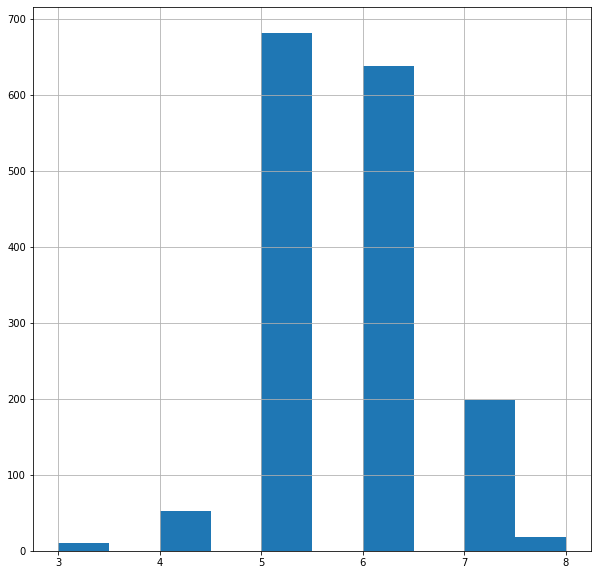

In [34]:
"""
Import the dataframe as df
Start by looking at the number of missing values and 
Class imbalance of the target variable. 
The model accuracy and other performance metric depends on this.
After that, we need to look for outliers in the dataset
Followed by the distributions of the variables and the correlation among them. 
If there's a high degree of correlation, it can mess with our model. 
"""
df = pd.read_csv('sperry_anti-freeze.csv')
print(df.describe())
print("\n")
#print(df.isnull().any()) uncomment this if you wish to see the number of missing values. In this dataset, there are no missing values. 
print("\n")
df['quality'].hist(figsize = (10,10)) #We can also use a dictionary here to see the counts. That might be needed if we're classifying into multiple categories

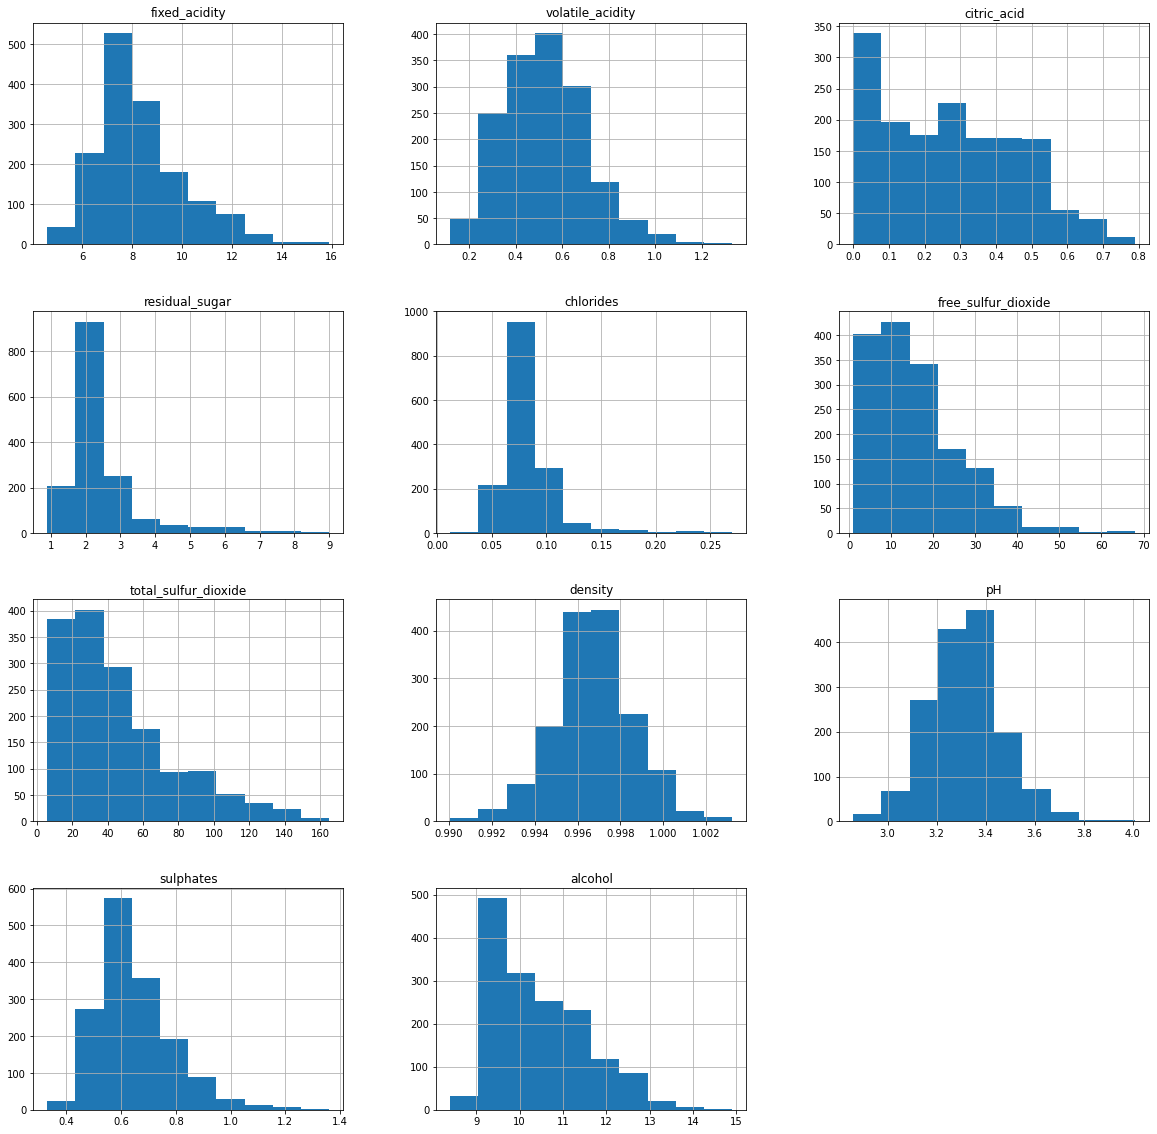

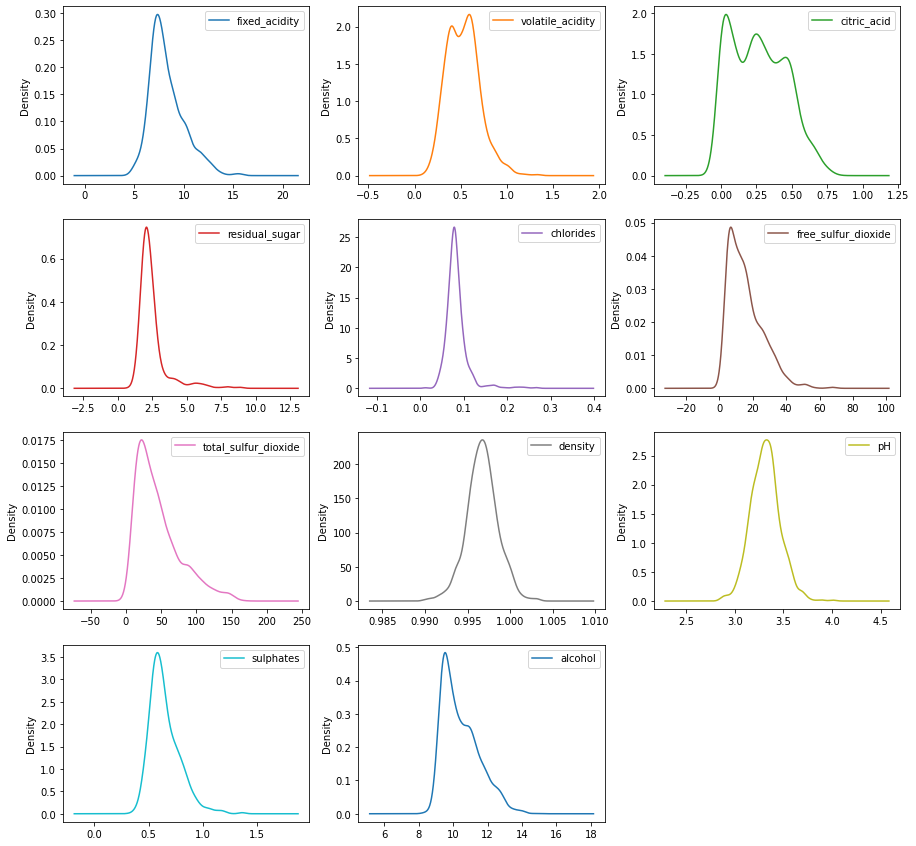

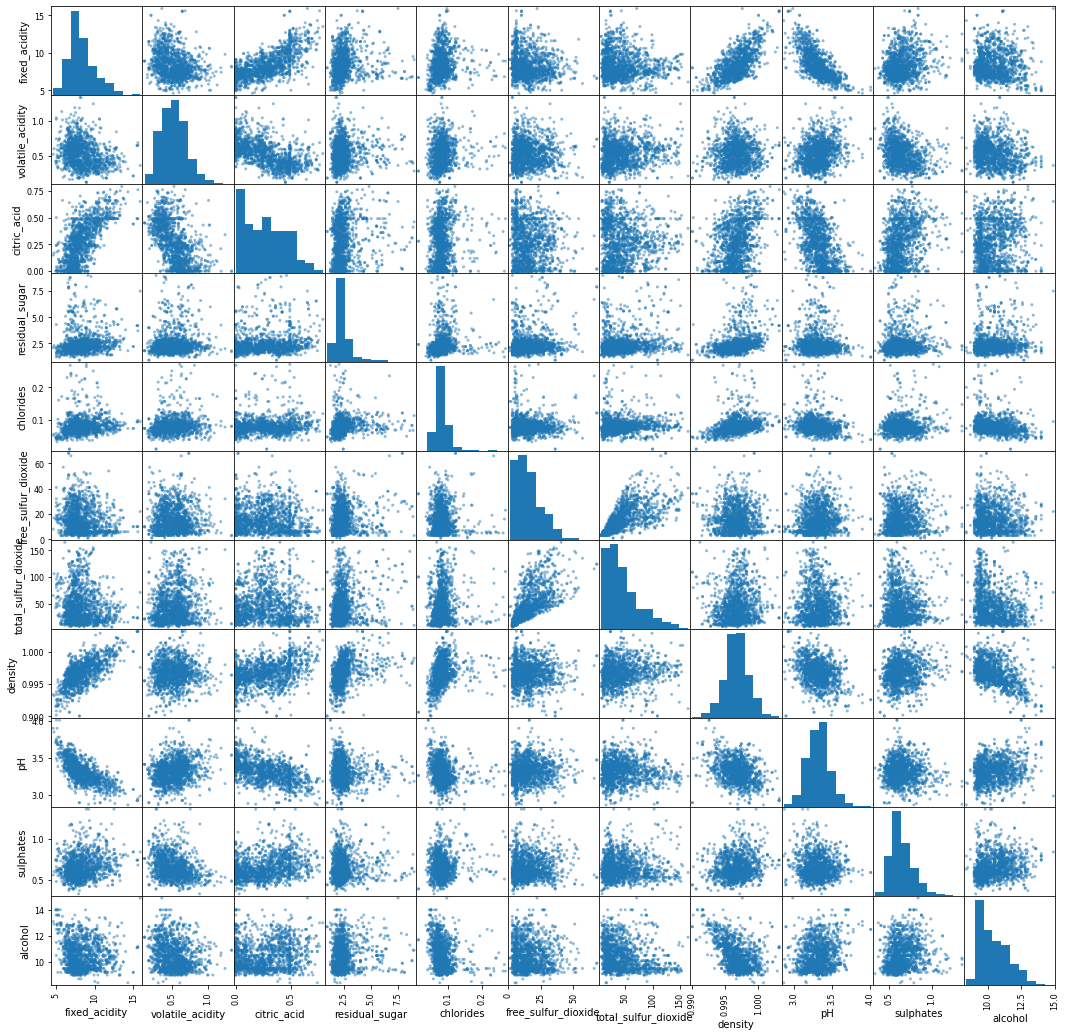

<AxesSubplot:>

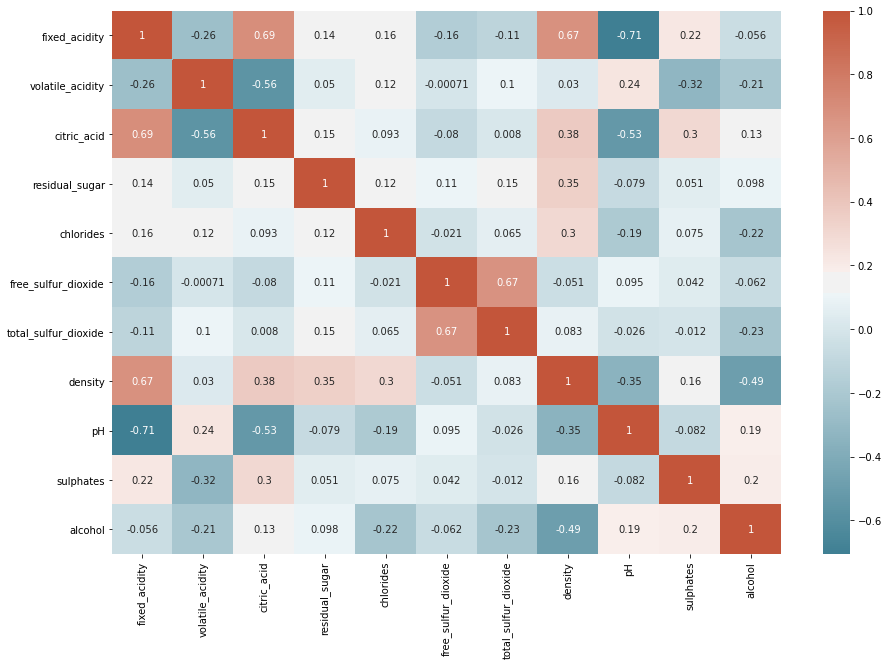

In [35]:
"""
The number of values seems to be evenly distributed and to encode this, 
choose '5' as the cut-off for the 'bad' label for the target
The custom function encode() does this for us. 
Following this, we need the distributions of other variables to see if there are any skewed ones. 
And the degree of correlation among various variables we see here. 
"""
def encode(x):
    if x <= 5:
        return 0
    else:
        return 1
df['quality'] = df['quality'].apply(encode)
z = np.abs(stats.zscore(df))
df = df[(z <= 5).all(axis=1)]
X = df.drop(['quality'],axis = 1)
Y = df['quality']
X.rename(columns = {'fixed acidity':'fixed_acidity','volatile acidity':'volatile_acidity','citric acid':'citric_acid','residual sugar':'residual_sugar',
          'free sulfur dioxide':'free_sulfur_dioxide','total sulfur dioxide':'total_sulfur_dioxide'},inplace = True)
X.hist(figsize = (20,20))
plt.show()
X.plot(kind='density',figsize = (15,15),subplots = True,layout = (4,3), sharex=False)
plt.show()
scatter_matrix(X, figsize = (18,18))
plt.show()
corr = X.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

       fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    1558.000000       1558.000000  1558.000000     1558.000000   
mean        8.317715          0.528383     0.265950        2.464987   
std         1.752651          0.177769     0.191775        1.066407   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.330000     0.790000        9.000000   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  1558.000000          1558.000000           1558.000000  1558.000000   
mean      0.082637            15.717587             45.666881     0.996719   
std       0.025365            10.239842             31.521324     0.001862   
min       0.012000             1.000000         

<AxesSubplot:>

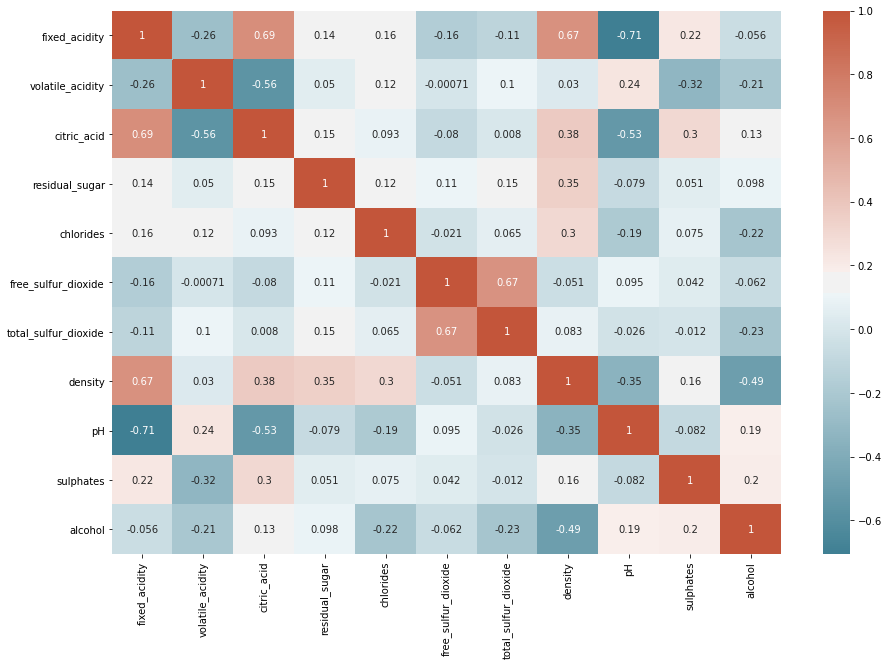

In [36]:
"""
Data Preprocessing:
There are a few things to be done here. 
One is to remove outliers and the other to standardize the values since they're on different scales here. 
"""

print(X.describe())
corr = X.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
#X_features = X
#sc = StandardScaler()
#X = sc.fit(X).transform(X)
#print(type(X))
#print(min(X[:,2]))

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state = 1,shuffle = True)
del df,X #Free up some memory
print(type(X_train))
print(X_train.shape)
print(X_test.shape)

<class 'pandas.core.frame.DataFrame'>
(1090, 11)
(468, 11)


In [38]:
#Naive predictor
#Predicting the output naively. 
TP = float(np.sum(Y))
FP = float(Y.count()-TP)
TN=0.0
FN=0.0
beta = 0.5
accuracy = (TP + TN)/(FP+FN+TP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
fscore =  (1.0 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.5372, F-score: 0.5920]


In [39]:
#Choose a few models
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report,fbeta_score,accuracy_score

dt = DecisionTreeClassifier(random_state=1)
rfc = RandomForestClassifier(random_state=1, n_jobs=2)
gdb = GradientBoostingClassifier(random_state=1)
abc = AdaBoostClassifier(random_state = 1)
xgbst = xgb.XGBClassifier(random_state=1)
classifiersList = [dt,rfc,gdb,abc,xgbst]
classifiersScores = []
classifiersTrainTimes = []

{0, 1}
DecisionTreeClassifier trained on 1090 samples.
              precision    recall  f1-score   support

           0       0.75      0.76      0.75       221
           1       0.78      0.78      0.78       247

    accuracy                           0.77       468
   macro avg       0.77      0.77      0.77       468
weighted avg       0.77      0.77      0.77       468



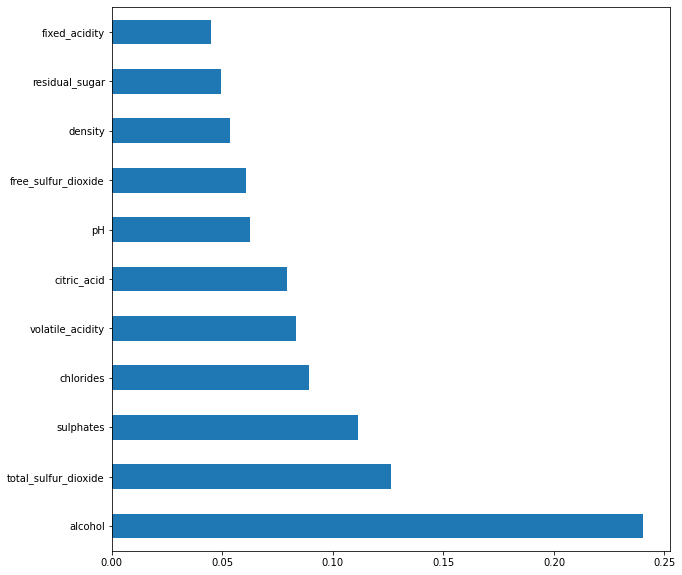



RandomForestClassifier trained on 1090 samples.
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       221
           1       0.83      0.84      0.84       247

    accuracy                           0.82       468
   macro avg       0.82      0.82      0.82       468
weighted avg       0.82      0.82      0.82       468



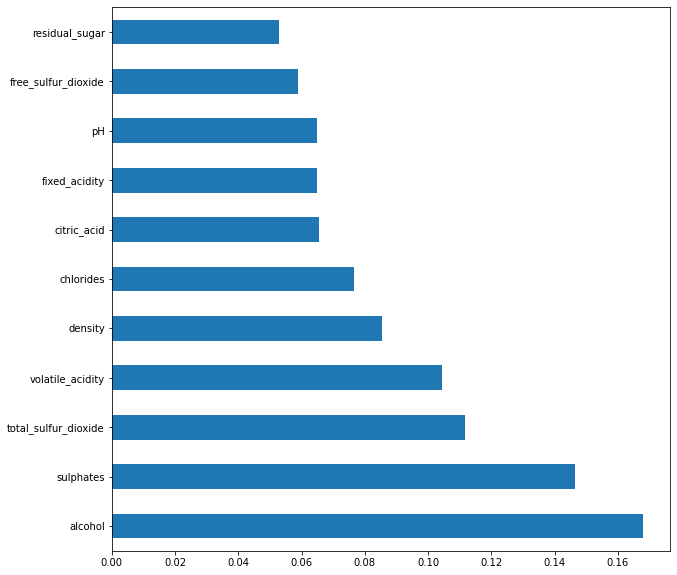



GradientBoostingClassifier trained on 1090 samples.
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       221
           1       0.81      0.79      0.80       247

    accuracy                           0.79       468
   macro avg       0.79      0.79      0.79       468
weighted avg       0.79      0.79      0.79       468



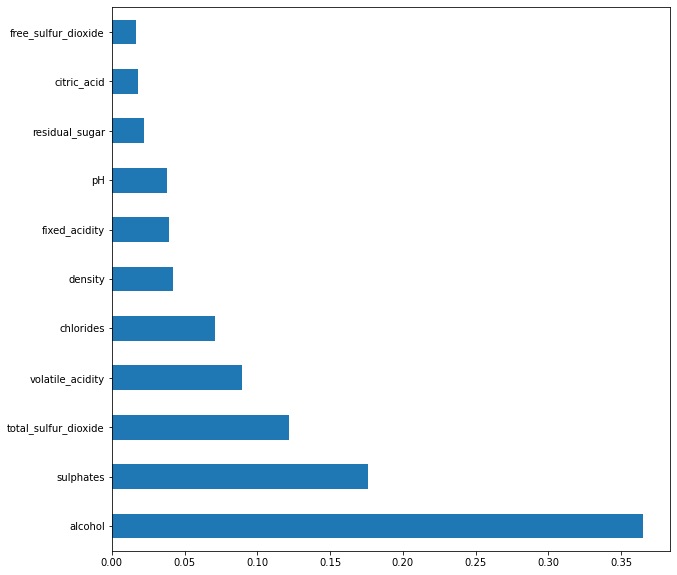



AdaBoostClassifier trained on 1090 samples.
              precision    recall  f1-score   support

           0       0.76      0.73      0.75       221
           1       0.77      0.80      0.78       247

    accuracy                           0.76       468
   macro avg       0.76      0.76      0.76       468
weighted avg       0.76      0.76      0.76       468



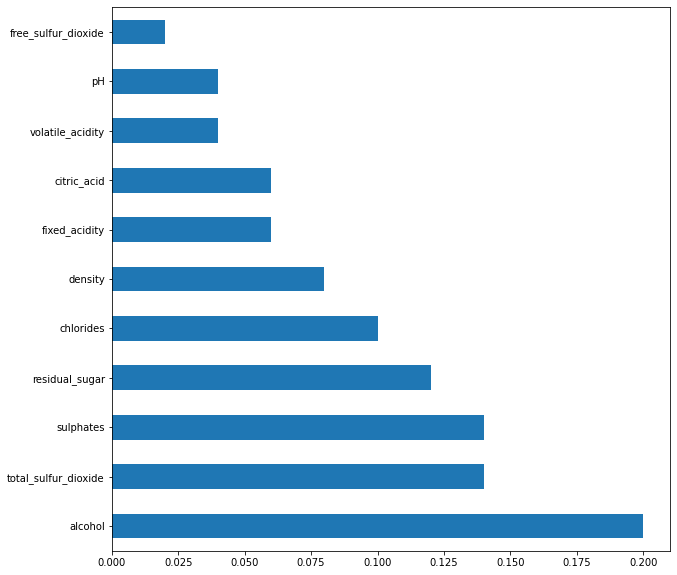



[22:57:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier trained on 1090 samples.
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       221
           1       0.82      0.85      0.84       247

    accuracy                           0.83       468
   macro avg       0.83      0.83      0.83       468
weighted avg       0.83      0.83      0.83       468



/home/bhargava/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


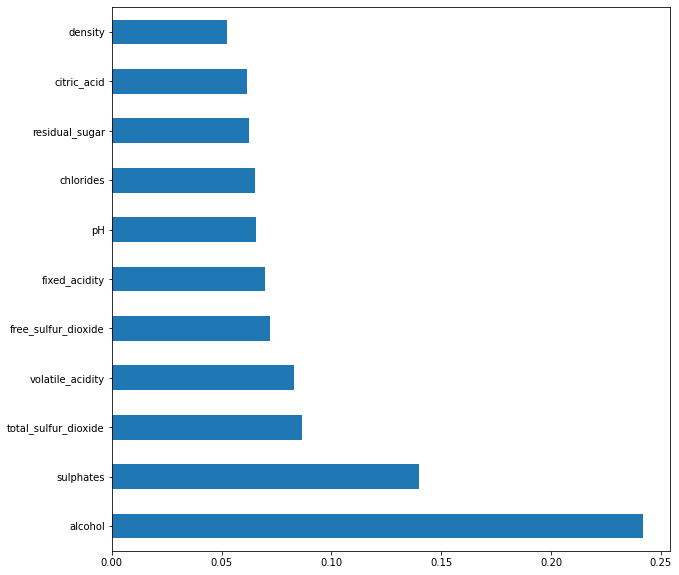



[0.7798537774167345, 0.8313349320543565, 0.803645401822701, 0.7725490196078432, 0.8300550747442959]
[0.018883705139160156, 0.3754749298095703, 0.29163312911987305, 0.14139008522033691, 0.12918543815612793]
[0.7670940170940171, 0.8247863247863247, 0.7884615384615384, 0.7649572649572649, 0.8269230769230769]
['DecisionTree', 'RandomForest', 'GradientBoosting', 'AdaBoost', 'XGB']
{0, 1}
DecisionTreeClassifier trained on 1090 samples.
RandomForestClassifier trained on 1090 samples.
GradientBoostingClassifier trained on 1090 samples.
AdaBoostClassifier trained on 1090 samples.
[22:57:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier trained on 1090 samples.
[0.7798537774167345, 0.8313349320543565, 0.803645401822701, 0.7725490196078432, 0.8300550747442959]
[0.01249384880065918, 0.35122

/home/bhargava/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [40]:
#Train the models
from time import time
print(set(y_train))
def trainPredict(model,sampleSize,x_train,y_train,x_test,y_test):
    '''
    model: The algorithm
    sampleSize: The size of samples to draw from
    x_train: Training dataset
    y_train: Labels 
    x_test: Test set
    y_test: Test labels
    '''
    results = {}
    #Training the model 
    start = time()
    learner = model.fit(x_train[:sampleSize],y_train[:sampleSize])
    end = time()
    results['training_time'] = end - start
    
    #Predictions 
    start = time()
    predictions_test = learner.predict(x_test)
    end = time()
    results['testing_time'] = end - start
    results['acc_train'] = accuracy_score(y_test,learner.predict(x_test))
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
    print ("{} trained on {} samples.".format(model.__class__.__name__, sampleSize))
    results['clf_name'] = model.__class__.__name__
    print(classification_report(y_test, predictions_test))
    feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(25).plot(kind='barh',figsize=(10,10))
    plt.show()
    print("\n")
    return results

#Create lists to store selected benchmarking results
clf_lscores = []
clf_ltrain_times = []
clf_lnames = []
clf_testAccuracies = []
clf_trainAccuracies = []

for model in classifiersList:
    #Train the various models on the same set of data to compare and choose the best model
    clfResults = trainPredict(model,len(y_train),X_train,y_train,X_test,y_test)
    clf_lscores.append(clfResults['f_test'])
    clf_ltrain_times.append(clfResults['training_time'])
    clf_testAccuracies.append(clfResults['acc_test'])
    clf_trainAccuracies.append(clfResults['acc_train'])
    clf_lnames.append(clfResults['clf_name'].replace('Classifier', ''))
print(clf_lscores)
print(clf_ltrain_times)
print(clf_testAccuracies)
print(clf_lnames)#Train the models
from time import time
print(set(y_train))
def trainPredict(model,sampleSize,x_train,y_train,x_test,y_test):
    '''
    model: The algorithm
    sampleSize: The size of samples to draw from
    x_train: Training dataset
    y_train: Labels 
    x_test: Test set
    y_test: Test labels
    '''
    results = {}
    #Training the model 
    start = time()
    learner = model.fit(x_train[:sampleSize],y_train[:sampleSize])
    end = time()
    results['training_time'] = end - start
    
    #Predictions 
    start = time()
    predictions_test = learner.predict(x_test)
    end = time()
    results['testing_time'] = end - start
    results['acc_train'] = accuracy_score(y_test,learner.predict(x_test))
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
    print ("{} trained on {} samples.".format(model.__class__.__name__, sampleSize))
    results['clf_name'] = model.__class__.__name__
    return results

#Create lists to store selected benchmarking results
clf_lscores = []
clf_ltrain_times = []
clf_lnames = []
clf_testAccuracies = []
clf_trainAccuracies = []

for model in classifiersList:
    #Train the various models on the same set of data to compare and choose the best model
    clfResults = trainPredict(model,len(y_train),X_train,y_train,X_test,y_test)
    clf_lscores.append(clfResults['f_test'])
    clf_ltrain_times.append(clfResults['training_time'])
    clf_testAccuracies.append(clfResults['acc_test'])
    clf_trainAccuracies.append(clfResults['acc_train'])
    clf_lnames.append(clfResults['clf_name'].replace('Classifier', ''))
print(clf_lscores)
print(clf_ltrain_times)
print(clf_testAccuracies)
print(clf_lnames)

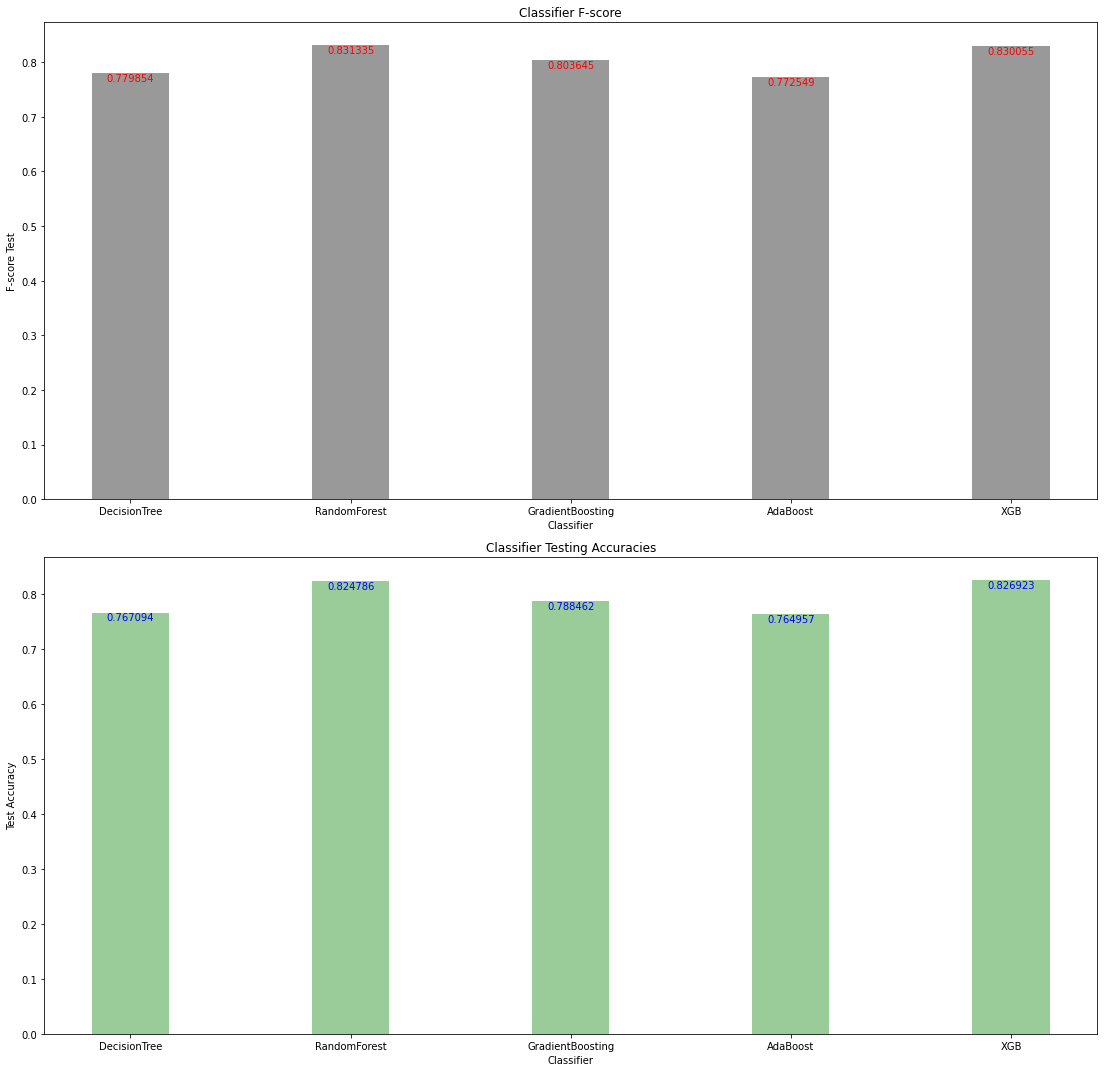

In [41]:
#Plot the results
plt.figure(1,figsize = (45,15))
nGroups = len(clf_lscores)
index = np.arange(nGroups)
barWidth = 0.35
opacity = 0.4
data1 = clf_lscores
data2 = clf_testAccuracies 
plt.subplot(2,3,1)
plt.xlabel('Classifier')
plt.ylabel('F-score Test')
plt.title('Classifier F-score')
plt.xticks(index, clf_lnames)
bar1 = plt.bar(index, data1, barWidth, alpha=opacity, color='k')
for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%f' % height, ha='center', va='top',color = 'red')
plt.subplot(2,3,4)
plt.xlabel('Classifier')
plt.ylabel('Test Accuracy')
plt.title('Classifier Testing Accuracies')
plt.xticks(index, clf_lnames)
bar2 = plt.bar(index, data2, barWidth, alpha=opacity, color='g')
for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%f' % height, ha='center', va='top',color = 'b')
plt.tight_layout()
plt.show()

In [42]:
"""
#Model Tuning
#Let's select a model and change the parameters and this can be done for different models 
#I'll choose the RandomForestClassifier and change its parameters to reflect the change in Accuracy and other things
"""
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

clf = RandomForestClassifier(random_state=42, n_jobs=2)
parameters = {'max_depth': [4,6,8,10,12], 'n_estimators': [100,200,300,400]}
scorer = make_scorer(fbeta_score,beta=0.5)

grid_obj = GridSearchCV(clf, parameters,scoring=scorer)

#Fit the grid object using fit(), training data and the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train)

#Get the estimator 
best_clf = grid_fit.best_estimator_

#Predictions using both the unoptimized and the optimized model 
predsUnoptimized = (clf.fit(X_train, y_train)).predict(X_test)
predsOptimized = best_clf.predict(X_test)

#Best fit parameters
print("Best gridsearch parameters\n------")
print(grid_fit.best_params_)

#Report the change in accuracies 
print("Unoptimized model characteristics\n-----")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test,predsUnoptimized)*100))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predsUnoptimized, beta = 0.5)))
print("\nOptimized model characteristics\n-----")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test,predsOptimized)*100))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predsOptimized, beta = 0.5)))

Best gridsearch parameters
------
{'max_depth': 12, 'n_estimators': 300}
Unoptimized model characteristics
-----
Accuracy score on testing data: 85.0427
F-score on testing data: 0.8598

Optimized model characteristics
-----
Accuracy score on testing data: 83.3333
F-score on testing data: 0.8450
